<a href="https://colab.research.google.com/github/martinfinis/coursera_assi/blob/master/coursera_ml_with_python_finale_notebook_02_with_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree

%matplotlib inline

## Helper function


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print('Confusion matrix, without normalization')
    print(cm)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
def calcStoreAndPrintResult(name, df_results, y, y_pre, y_prob = None):
  """
  | Algorithm          | Jaccard | F1-score | Accuracy | LogLoss | confusion_matrix
  """
  jaccard = jaccard_score(y, y_pre, average='weighted')
  f1 = f1_score(y,y_pre, average='weighted')
  acc = accuracy_score(y,y_pre)
  
  if (y_prob is None ):
    logLoss = 'no prob'
  else:
    logLoss = log_loss(y,y_prob)
  
  print(f"jaccard: {jaccard}")
  print(f"f1: {f1}")
  print(f"acc: {acc}")
  print(f"log_loss: {logLoss}")
  
  cm_train = confusion_matrix(y, y_pre)
  
  new_row = {'algorithm':name, 'jaccard':jaccard,\
             'f1':f1,'acc':acc, 'log_loss':logLoss,\
             'confusion_matrix' : cm_train}

  print(f"confusion_matrix train")
  plot_confusion_matrix(cm_train,classes=['PAIDOFF','COLLECTION'],title="confusion_matrix train")
             
  #append row to the dataframe
  df_results = df_results.append(new_row, ignore_index=True)
  
  return df_results

In [ ]:
# collect all results in a data frame
df_results = pd.DataFrame(columns=['algorithm', 'jaccard', 'f1', 'acc' , 'log_loss'])

## About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [ ]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2022-07-15 14:00:04--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2022-07-15 14:00:05 (170 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [ ]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [ ]:
df.shape

(346, 10)

### Convert to date time object


In [ ]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [ ]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [ ]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

/bin/bash: conda: command not found


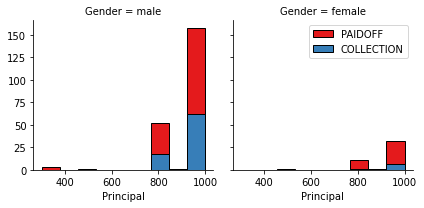

In [ ]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

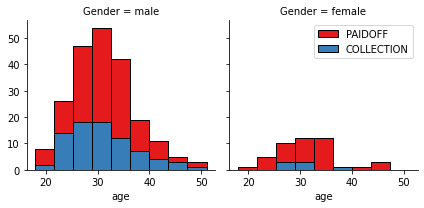

In [ ]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


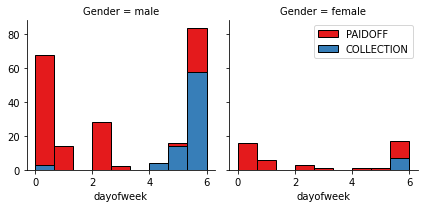

In [ ]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [ ]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


In [ ]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

Let's look at gender:


In [ ]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [ ]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [ ]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [ ]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [ ]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [ ]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [ ]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [ ]:
#X= preprocessing.StandardScaler().fit(X).transform(X)

ss = preprocessing.StandardScaler().fit(X)
X = ss.transform(X)

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


## K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


maf:


> To use scikit-learn library, we have to convert the Pandas data frame to a Numpy array

> Data Standardization gives the data zero mean and unit variance, it is good practice, especially for algorithms such as KNN which is based on the distance of data points:



In [ ]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
X_train = X
y_train = y
print ('Train set:', X_train.shape,  y_train.shape)

Train set: (346, 8) (346,)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [ ]:
Ks = 20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_train)
    mean_acc[n-1] = metrics.accuracy_score(y_train, yhat)

    
    std_acc[n-1]=np.std(yhat==y_train)/np.sqrt(yhat.shape[0])

mean_acc

array([0.86705202, 0.84104046, 0.82080925, 0.81213873, 0.81213873,
       0.80346821, 0.80057803, 0.80346821, 0.80346821, 0.79479769,
       0.80057803, 0.80924855, 0.78323699, 0.78034682, 0.76878613,
       0.77456647, 0.75433526, 0.76589595, 0.75722543])

#### Plot the model accuracy for a different number of neighbors.


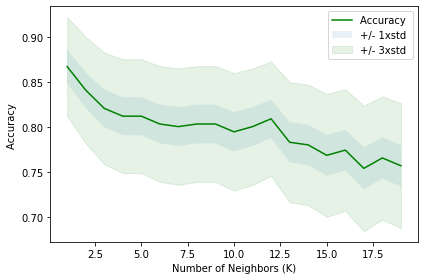

In [ ]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

jaccard: 0.6812392809502635
f1: 0.7943010665146952
acc: 0.8092485549132948
log_loss: no prob
confusion_matrix train
Confusion matrix, without normalization
[[ 38  48]
 [ 18 242]]
Normalized confusion matrix


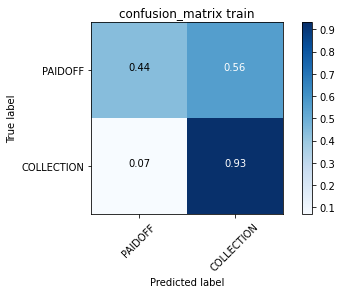

,algorithm,jaccard,f1,acc,log_loss,confusion_matrix
0,KNN 12,0.681239,0.794301,0.809249,no prob,"[[38, 48], [18, 242]]"


In [ ]:
knnModel = KNeighborsClassifier(n_neighbors = 12).fit(X_train,y_train)
y_pre=knnModel.predict(X_train)

df_results = calcStoreAndPrintResult('KNN 12',df_results,y_train,y_pre)
df_results

## Decision Tree


In [ ]:
dtModel = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
dtModel.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

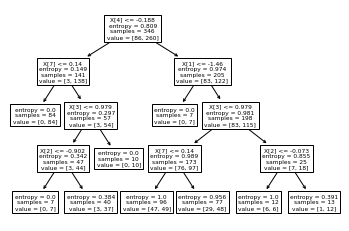

<Figure size 864x864 with 0 Axes>

In [ ]:
tree.plot_tree(dtModel)
plt.figure(figsize=(12,12))
plt.show()

jaccard: 0.5775837854619104
f1: 0.673085302317342
acc: 0.7514450867052023
log_loss: no prob
confusion_matrix train
Confusion matrix, without normalization
[[  6  80]
 [  6 254]]
Normalized confusion matrix


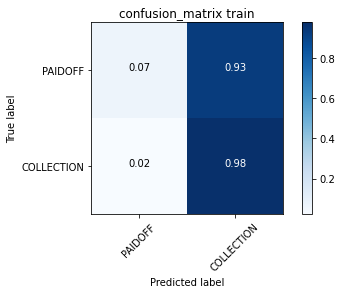

In [ ]:
y_pred_train = dtModel.predict(X_train)
df_results = calcStoreAndPrintResult('DecisionTree',df_results,y_train,y_pred_train)

## Support Vector Machine


### kernel=linear

In [ ]:
from sklearn import svm
import sklearn.preprocessing as pp

svmLinearModel = svm.SVC(kernel="linear", probability=True, random_state=42)
svmLinearModel.fit(X_train, y_train)

y_pred_train = svmLinearModel.predict(X_train)
y_prob_train = svmLinearModel.predict_proba(X_train)[:,1]

jaccard: 0.564669718333389
f1: 0.6448043648295465
acc: 0.7514450867052023
log_loss: 0.5608203486254122
confusion_matrix train
Confusion matrix, without normalization
[[  0  86]
 [  0 260]]
Normalized confusion matrix


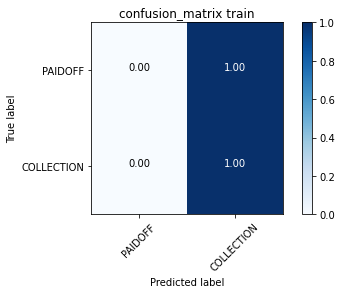

In [ ]:
df_results = calcStoreAndPrintResult('SVM linear',df_results,y_train,y_pred_train,y_prob_train)

In [ ]:
df_results

,algorithm,jaccard,f1,acc,log_loss,confusion_matrix
0,KNN 12,0.681239,0.794301,0.809249,no prob,"[[38, 48], [18, 242]]"
1,DecisionTree,0.577584,0.673085,0.751445,no prob,"[[6, 80], [6, 254]]"
2,SVM linear,0.564670,0.644804,0.751445,0.56082,"[[0, 86], [0, 260]]"


### kernel='rbf'

jaccard: 0.5782790407657695
f1: 0.6647688577527595
acc: 0.7601156069364162
log_loss: 0.5129905241947901
confusion_matrix train
Confusion matrix, without normalization
[[  3  83]
 [  0 260]]
Normalized confusion matrix


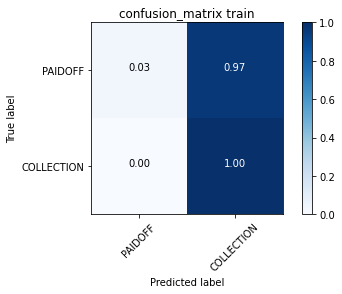

,algorithm,jaccard,f1,acc,log_loss,confusion_matrix
0,KNN 12,0.681239,0.794301,0.809249,no prob,"[[38, 48], [18, 242]]"
1,DecisionTree,0.577584,0.673085,0.751445,no prob,"[[6, 80], [6, 254]]"
2,SVM linear,0.564670,0.644804,0.751445,0.56082,"[[0, 86], [0, 260]]"
3,SVM rbf,0.578279,0.664769,0.760116,0.512991,"[[3, 83], [0, 260]]"


In [ ]:
svmRbfModel = svm.SVC(kernel="rbf", probability=True, random_state=42)
svmRbfModel.fit(X_train, y_train)

y_pred_train = svmRbfModel.predict(X_train)
y_prob_train = svmRbfModel.predict_proba(X_train)[:,1]

df_results = calcStoreAndPrintResult('SVM rbf',df_results,y_train,y_pred_train,y_prob_train)
df_results

### kernel='polynomial'

jaccard: 0.6162498798077158
f1: 0.7180059052130698
acc: 0.7803468208092486
log_loss: 0.4988715454864
confusion_matrix train
Confusion matrix, without normalization
[[ 13  73]
 [  3 257]]
Normalized confusion matrix


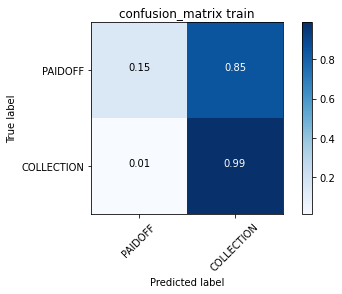

,algorithm,jaccard,f1,acc,log_loss,confusion_matrix
0,KNN 12,0.681239,0.794301,0.809249,no prob,"[[38, 48], [18, 242]]"
1,DecisionTree,0.577584,0.673085,0.751445,no prob,"[[6, 80], [6, 254]]"
2,SVM linear,0.564670,0.644804,0.751445,0.56082,"[[0, 86], [0, 260]]"
3,SVM rbf,0.578279,0.664769,0.760116,0.512991,"[[3, 83], [0, 260]]"
4,SVM polynomial,0.616250,0.718006,0.780347,0.498872,"[[13, 73], [3, 257]]"


In [ ]:
svmPolynomialModel = svm.SVC(kernel="poly", probability=True, random_state=42)
svmPolynomialModel.fit(X_train, y_train)

y_pred_train = svmPolynomialModel.predict(X_train)
y_prob_train = svmPolynomialModel.predict_proba(X_train)[:,1]

df_results = calcStoreAndPrintResult('SVM polynomial',df_results,y_train,y_pred_train,y_prob_train)
df_results

### kernel='sigmoid'

jaccard: 0.5405017757367594
f1: 0.6320215591313857
acc: 0.7167630057803468
log_loss: 0.5363027904290005
confusion_matrix train
Confusion matrix, without normalization
[[  1  85]
 [ 13 247]]
Normalized confusion matrix


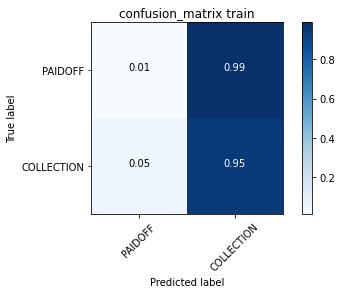

,algorithm,jaccard,f1,acc,log_loss,confusion_matrix
0,KNN 12,0.681239,0.794301,0.809249,no prob,"[[38, 48], [18, 242]]"
1,DecisionTree,0.577584,0.673085,0.751445,no prob,"[[6, 80], [6, 254]]"
2,SVM linear,0.564670,0.644804,0.751445,0.56082,"[[0, 86], [0, 260]]"
3,SVM rbf,0.578279,0.664769,0.760116,0.512991,"[[3, 83], [0, 260]]"
4,SVM polynomial,0.616250,0.718006,0.780347,0.498872,"[[13, 73], [3, 257]]"
5,SVM sigmoid,0.540502,0.632022,0.716763,0.536303,"[[1, 85], [13, 247]]"


In [ ]:
svmRbfModel = svm.SVC(kernel="sigmoid", probability=True, random_state=42)
svmRbfModel.fit(X_train, y_train)

y_pred_train = svmRbfModel.predict(X_train)
y_prob_train = svmRbfModel.predict_proba(X_train)[:,1]

df_results = calcStoreAndPrintResult('SVM sigmoid',df_results,y_train,y_pred_train,y_prob_train)
df_results

## Logistic Regression


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

lrModel = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
lrModel

LogisticRegression(C=0.01, solver='liblinear')

jaccard: 0.5624979117244144
f1: 0.6433860411789996
acc: 0.7485549132947977
log_loss: 0.5430553956239154
confusion_matrix train
Confusion matrix, without normalization
[[  0  86]
 [  1 259]]
Normalized confusion matrix


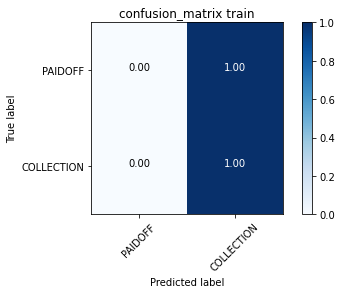

In [ ]:
y_pred_train = lrModel.predict(X_train)
y_prob_train = lrModel.predict_proba(X_train)
df_results = calcStoreAndPrintResult('LogisticRegression',df_results,y_train,y_pred_train,y_prob_train,)

In [ ]:
df_results

,algorithm,jaccard,f1,acc,log_loss,confusion_matrix
0,KNN 12,0.681239,0.794301,0.809249,no prob,"[[38, 48], [18, 242]]"
1,DecisionTree,0.577584,0.673085,0.751445,no prob,"[[6, 80], [6, 254]]"
2,SVM linear,0.564670,0.644804,0.751445,0.56082,"[[0, 86], [0, 260]]"
3,SVM rbf,0.578279,0.664769,0.760116,0.512991,"[[3, 83], [0, 260]]"
4,SVM polynomial,0.616250,0.718006,0.780347,0.498872,"[[13, 73], [3, 257]]"
5,SVM sigmoid,0.540502,0.632022,0.716763,0.536303,"[[1, 85], [13, 247]]"
6,LogisticRegression,0.562498,0.643386,0.748555,0.543055,"[[0, 86], [1, 259]]"


# Model Evaluation using Test set


In [ ]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:


In [ ]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2022-07-15 14:00:11--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2022-07-15 14:00:11 (940 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [ ]:
test_df = pd.read_csv('loan_test.csv')
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [ ]:
test_feature = test_df[['Principal','terms','age','Gender','weekend']]
test_feature = pd.concat([test_feature,pd.get_dummies(test_df['education'])], axis=1)
test_feature.drop(['Master or Above'], axis = 1,inplace=True)
test_feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [ ]:
X_test = ss.transform(test_feature)
y_test = test_df['loan_status']

' test KNN'

jaccard: 0.5175479462691203
f1: 0.626541384672668
acc: 0.6851851851851852
log_loss: no prob
confusion_matrix train
Confusion matrix, without normalization
[[ 1 13]
 [ 4 36]]
Normalized confusion matrix


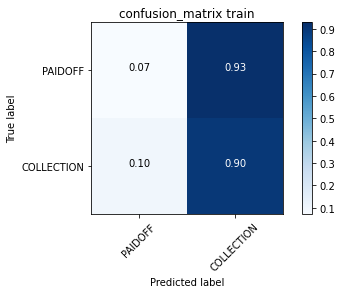

' test Decision Tress'

jaccard: 0.5901234567901235
f1: 0.6959228135698723
acc: 0.7592592592592593
log_loss: no prob
confusion_matrix train
Confusion matrix, without normalization
[[ 2 12]
 [ 1 39]]
Normalized confusion matrix


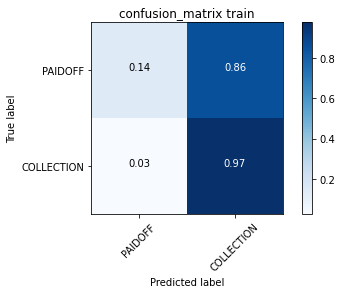

' test Support Vector Machine'

jaccard: 0.5028136378682555
f1: 0.6151515151515151
acc: 0.6666666666666666
log_loss: 0.6553104198353787
confusion_matrix train
Confusion matrix, without normalization
[[ 1 13]
 [ 5 35]]
Normalized confusion matrix


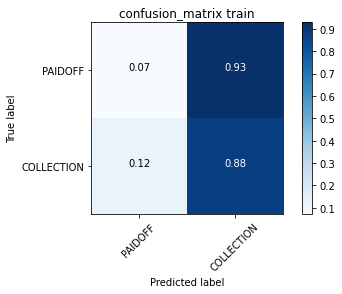

' test Logistic Regression'

jaccard: 0.5775681341719078
f1: 0.6717642373556352
acc: 0.7592592592592593
log_loss: 0.5563591871478355
confusion_matrix train
Confusion matrix, without normalization
[[ 1 13]
 [ 0 40]]
Normalized confusion matrix


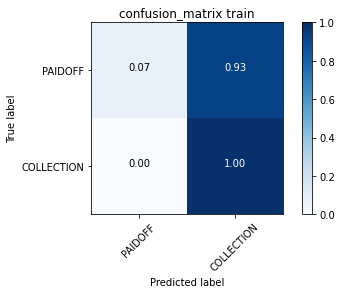

,algorithm,jaccard,f1,acc,log_loss,confusion_matrix
0,KNN 12,0.517548,0.626541,0.685185,no prob,"[[1, 13], [4, 36]]"
1,DecisionTree,0.590123,0.695923,0.759259,no prob,"[[2, 12], [1, 39]]"
2,SVM sigmoid,0.502814,0.615152,0.666667,0.65531,"[[1, 13], [5, 35]]"
3,Logistic Regression,0.577568,0.671764,0.759259,0.556359,"[[1, 13], [0, 40]]"


In [ ]:
df_results = pd.DataFrame(columns=['algorithm', 'jaccard', 'f1', 'acc' , 'log_loss'])

display(" test KNN")
y_pred_test=knnModel.predict(X_test)
df_results = calcStoreAndPrintResult('KNN 12',df_results,y_test,y_pred_test)


display(" test Decision Tress")
y_pred_test = dtModel.predict(X_test)
df_results = calcStoreAndPrintResult('DecisionTree',df_results,y_test,y_pred_test)

display(" test Support Vector Machine")
y_pred_test = svmRbfModel.predict(X_test)
y_prob_test = svmRbfModel.predict_proba(X_test)[:,1]
df_results = calcStoreAndPrintResult('SVM sigmoid',df_results,y_test,y_pred_test,y_prob_test)

display(" test Logistic Regression")
y_pred_test = lrModel.predict(X_test)
y_prob_test = lrModel.predict_proba(X_test)
df_results = calcStoreAndPrintResult('Logistic Regression',df_results,y_test,y_pred_test,y_prob_test)

df_results

In [ ]:
%ldir

drwxr-xr-x 1 root  4096 Jul 13 13:43 sample_data/


In [ ]:
%whos

Variable                  Type                      Data/Info
-------------------------------------------------------------
DecisionTreeClassifier    ABCMeta                   <class 'sklearn.tree._cla<...>.DecisionTreeClassifier'>
Feature                   DataFrame                      Principal  terms  ag<...>n\n[346 rows x 8 columns]
KNeighborsClassifier      ABCMeta                   <class 'sklearn.neighbors<...>on.KNeighborsClassifier'>
Ks                        int                       20
LogisticRegression        type                      <class 'sklearn.linear_mo<...>stic.LogisticRegression'>
NullFormatter             type                      <class 'matplotlib.ticker.NullFormatter'>
X                         ndarray                   346x8: 2768 elems, type `float64`, 22144 bytes
X_test                    ndarray                   54x8: 432 elems, type `float64`, 3456 bytes
X_train                   ndarray                   346x8: 2768 elems, type `float64`, 22144 bytes
a

# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


# aboute report

https://stats.stackexchange.com/questions/420416/does-knn-have-a-loss-function


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
